In [1]:
import os, sys
sys.path.append('.')

# Regular Modules
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy.random import default_rng
import matplotlib.tri as tri
import datetime
import itertools

# My Modules
import src.helpers as helpers
import src.model_systems as model_systems
import src.diffusion_map as dmap



## Set Parameters for plotting, etc.

In [2]:
# Setting inverse temperature for plotting
beta = 1.0
target_beta = 1.0

def potential(x): return model_systems.morocardin_potential(x)
def drift(x): return model_systems.morocardin_drift(x)
def measure(x): return np.exp(-beta*potential(x))

xmin, xmax = -2, 2
ymin, ymax = -2, 2
nx, ny = 128, 128
volume = (xmax - xmin)*(ymax - ymin)

## Pick Dataset and Method

In [3]:
#################################
dataset = 'metad'
method = 'targetMMAP'
#################################
fname = f"systems/MoroCardin/data/data_solution_{dataset}.npz"
inData = np.load(fname)
data = inData['data']
diffusion_list = inData['diffusion_list']

#data = data[:, ::2]
#diffusion_list = diffusion_list[::2, :, :]
N = data.shape[1]
print("number of data points: %d" % N)

triang = tri.Triangulation(data[0, :], data[1, :])

number of data points: 10000


### For Committor: Define A, B sets

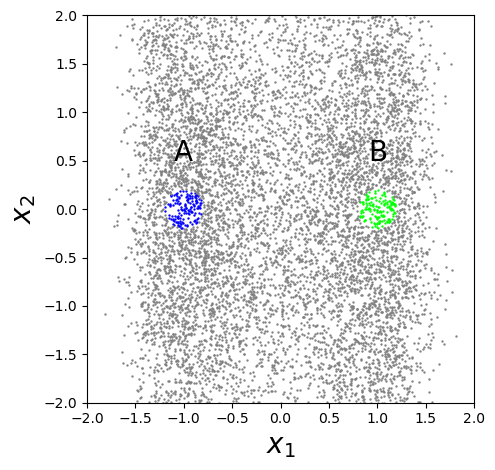

In [4]:
# For setting, A,B based on circles
center_A = np.array([-1, 0])
center_B = np.array([1, -0])
radius_A = 0.2
radius_B = 0.2
    
dist_A = np.sqrt(np.sum((center_A[..., np.newaxis] - data)**2, axis=0))
dist_B = np.sqrt(np.sum((center_B[..., np.newaxis] - data)**2, axis=0))

A_bool = dist_A < radius_A
B_bool = dist_B < radius_B 
C_bool = ~np.logical_or(A_bool, B_bool)

A_test = data[:, A_bool]
B_test= data[:, B_bool]
C_test = data[:, C_bool]

import matplotlib
my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

fig = plt.figure() 
#plt.scatter(data[0, :], data[1, :], s=0.5, color='gray')
plt.scatter(A_test[0, :], A_test[1, :], s=0.5, color=A_color)
plt.scatter(B_test[0, :], B_test[1, :], s=0.5, color=B_color)
plt.scatter(C_test[0, :], C_test[1, :], s=0.5, color='gray')
plt.gca().text(-1.1, 0.5, 'A', fontsize=20)
plt.gca().text(0.9, 0.5, 'B', fontsize=20)

#xmin, xmax = -np.pi, np.pi
#ymin, ymax = -np.pi, np.pi
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
#plt.xlim([-1.1, -0.9])
#plt.ylim([-0.5, 0.5])
plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')



loading Ksum epsilon for kde kernel
optimal eps: 0.005524271728019903
computing RNN kernel
nodes left after removing isolated: 10000
ratio of nonzeros: 0.83552004
shifting to dense
Doing dense matrix calculations
approximate Z via dmaps: 10.063423710510344


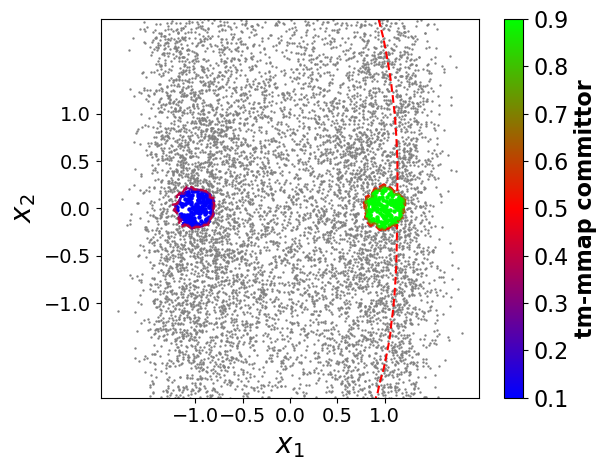

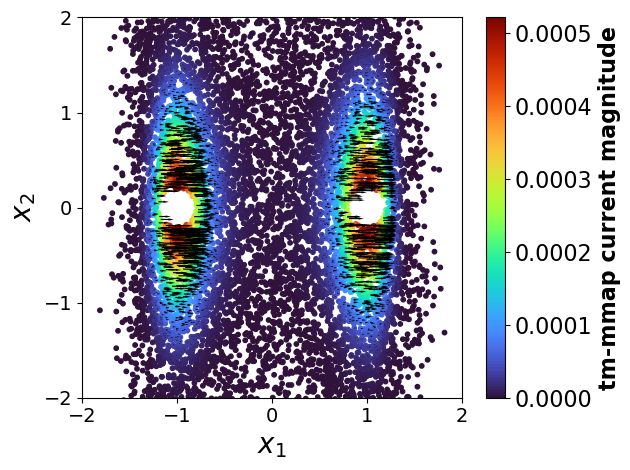

In [11]:
method = 'targetDMAP'
if method == 'targetMMAP':
    kernel = 'mahal'
    print('loading Ksum epsilon for mahal kernel')
if method == 'targetDMAP':
    kernel = 'regular'
    print('loading Ksum epsilon for kde kernel')
fname = f"systems/MoroCardin/data/Ktest_{dataset}_{kernel}.npz"
inData = np.load(fname)
optimal_eps = inData["optimal_eps"]
print(f"optimal eps: {optimal_eps}")
###########################################################################
# Compute a diffusion map
###########################################################################
eps = 10
radius = None
kde_eps = None
n_neigh = 512
density_mode = None
neigh_mode = "RNN"
rho = None

# Compute target measure
target_beta = 1
target_measure = np.zeros(N)
for i in range(N):
    target_measure[i] = np.exp(-target_beta*potential(data[:, i]))

##### Compute some sort of diffusion map 
if method == 'MMAP' or method == 'targetMMAP':
    if method == 'MMAP':
        rho = None
        target_measure = None
    my_dmap = dmap.TargetMeasureMahalanobisDiffusionMap(epsilon=eps, diffusion_list=diffusion_list,
                                                        kde_epsilon=kde_eps, density_mode=density_mode, 
                                                        radius=radius, n_neigh=n_neigh, neigh_mode=neigh_mode,
                                                        rho=rho, target_measure=target_measure, 
                                                        remove_isolated=True, pbc_dims=None)

if method == 'DMAP' or method =='targetDMAP':
    if method == 'DMAP':
        rho = None
        target_measure = None
    my_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps, radius=radius, n_neigh=n_neigh, 
                                                neigh_mode=neigh_mode,rho=rho, 
                                                target_measure=target_measure, 
                                                remove_isolated=True, pbc_dims=None)

my_dmap.construct_generator(data)
q, subgraph  = my_dmap.construct_committor(B_bool, C_bool)
L = my_dmap.get_generator()

nonisolated_bool = subgraph["nonisolated_bool"] 
data_nonisolated = data[:, nonisolated_bool]


##########################################################################
# Compute normalizing constant for dmap
##########################################################################
N = L.shape[0]
if method == 'targetMMAP':
    sqdists = my_dmap._compute_sqdists(data_nonisolated, metric=None)
else:
    sqdists = my_dmap._compute_sqdists(data_nonisolated)
kde = np.sum(np.exp(-sqdists/(2*eps)), axis=1) 
kde = kde*(N*2*np.pi*eps)**(-1)
target_measure_noniso = target_measure[nonisolated_bool]
Z_dmap = (1/N)*np.sum(target_measure_noniso / kde)
print(f"approximate Z via dmaps: {Z_dmap}")
    
xbox_min = -0.4
xbox_max = 0.4
ybox_min = -1.0
ybox_max = 1.0

xbox_min = -1.0
xbox_max = 1.0
ybox_min = -1.0
ybox_max = 1.0

#######################################################################
# Compute contours
#######################################################################
fig,ax = plt.subplots()
plt.scatter(data_nonisolated[0, :], data_nonisolated[1, :], s=0.5, color='gray')
my_levels = helpers.committor_contours()
cmap = 'brg'
C1=plt.tricontour(triang, q, levels=my_levels, linewidths=1.5, cmap=cmap, linestyles='dashed')
norm= matplotlib.colors.Normalize(vmin=C1.cvalues.min(), vmax=C1.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = C1.cmap)
sm.set_array([])
cbar = fig.colorbar(sm, ticks=C1.levels)
tick_font_size = 16
cbar.ax.tick_params(labelsize=tick_font_size)
cbar.set_label(label='tm-mmap committor', size=16, weight='bold')

plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xticks(np.linspace(xbox_min, xbox_max, 5), fontsize=14)
plt.yticks(np.linspace(ybox_min, ybox_max, 5), fontsize=14)

my_cmap = matplotlib.cm.get_cmap('brg')
A_color= my_cmap(0.0)
B_color = my_cmap(1.0)

plt.scatter(A_test[0, :], A_test[1, :], s=5, color=A_color)
plt.scatter(B_test[0, :], B_test[1, :], s=5, color=B_color)

plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

############################################################################
## Compute and Plot Currents
############################################################################
subgraph_AB_bool = np.logical_and(nonisolated_bool, C_bool) 
plot_data = data[:, subgraph_AB_bool]
current_x = (1./(Z_dmap*beta)) * target_measure[nonisolated_bool]*(helpers.duchamp(L, q, data[0, nonisolated_bool])).flatten()
current_y =  (1./(Z_dmap*beta)) * target_measure[nonisolated_bool]*(helpers.duchamp(L, q, data[1, nonisolated_bool])).flatten()
current = np.vstack([current_x, current_y])
plot_current = np.zeros((2, data.shape[1]))
plot_current[:, nonisolated_bool] = current
plot_current = plot_current[:, subgraph_AB_bool] 
    
# Current isn't defined on A or B
A_bool_nonisolated = A_bool[nonisolated_bool]
B_bool_nonisolated = B_bool[nonisolated_bool]
C_bool_nonisolated = C_bool[nonisolated_bool]
plot_curr_mag = np.sqrt(plot_current[0, :]**2 + plot_current[1, :]**2)
    
plt.figure() 

cmap = 'turbo'
plt.scatter(plot_data[0, :], plot_data[1, :], s=10.0, c=plot_curr_mag, cmap=cmap)
cbar = plt.colorbar()
cbar.set_label(label='tm-mmap current magnitude', size=16, weight='bold')
tick_font_size = 16
cbar.ax.tick_params(labelsize=tick_font_size)
plt.quiver(plot_data[0, ::2], plot_data[1, ::2], plot_current[0, ::2], plot_current[1, ::2], angles='xy', scale_units='xy', width=0.003, minlength=0, headwidth=2)
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xticks(np.linspace(xmin, xmax, 5), fontsize=14)
plt.yticks(np.linspace(ymin, ymax, 5), fontsize=14)

plt.xlabel(r'$x_1$', size=20)
plt.ylabel(r'$x_2$', size=20)
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')

## Trying out eigenfunctions and stuff

In [12]:
#my_dmap = dmap.TargetMeasureDiffusionMap(epsilon=eps, radius=radius, n_neigh=n_neigh, 
#                                                neigh_mode=neigh_mode,rho=rho, 
#                                                target_measure=target_measure, 
#                                                remove_isolated=True, pbc_dims=None, num_evecs=8)

my_dmap.fit(data)

computing RNN kernel
nodes left after removing isolated: 10000
ratio of nonzeros: 0.83552004
shifting to dense
Doing dense matrix calculations


(10000, 1)
[-0.08970492]


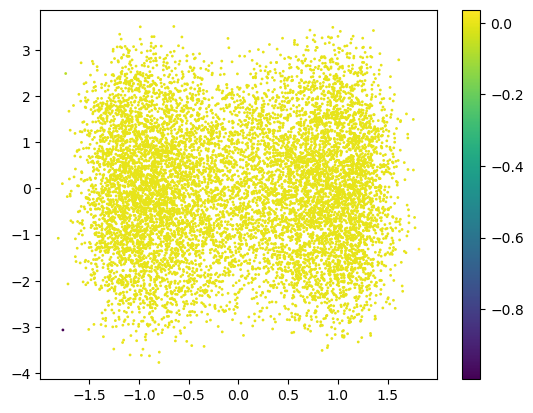

In [13]:
evecs = my_dmap.get_evecs()
print(evecs.shape)
print(my_dmap.evals)
#plt.scatter(evecs[:, 0], evecs[:, 1], c=data[0, :])

plt.figure()
plt.scatter(data[0, :], data[1, :], c=evecs[:,0], s=1)
plt.colorbar()
